In [1]:
import sys
sys.path.append("../")
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from mfmodeling import SingleGP, NARGP
from time import time as timer
import pickle

2025-09-24 20:36:32.773621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/maeyama/mylib/Miniforge3/envs/subB_3.12.11/lib/python3.12/site-packages/gpflow/versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Preparation of data set

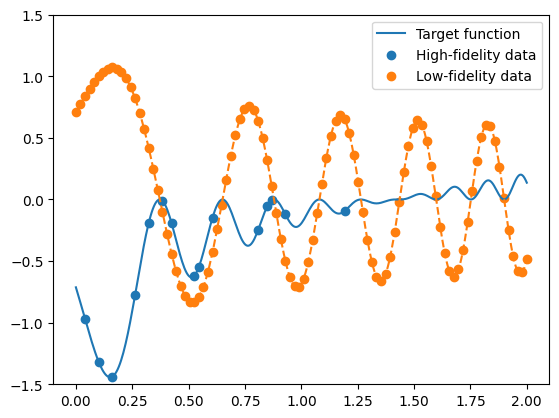

In [2]:
np.random.seed(24)
tf.random.set_seed(24)

''' function definitions '''
def high(x):
    return (x-np.sqrt(2))*low(x)**2

def low(x):
    Ai, Aip, Bi, Bip = sp.special.airy(-2*np.pi*x)
    return 2*Ai

''' Define training and test points '''
dim = 1
s = 2
plot = 1
N1 = 100
N2 = np.array([15])

Nts = 400
Xtest = np.linspace(0,2, Nts)[:,None]
Exact= high(Xtest)
Low = low(Xtest)

X1 = np.linspace(0,2, N1)[:,None]
# perm = np.random.permutation(N1)
perm = np.random.permutation(int(N1*0.6))
X2 = X1[perm[0:N2[0]]]

Y1 = low(X1)
Y2 = high(X2)

plt.plot(Xtest,Exact,label="Target function")
plt.plot(Xtest,Low,"--")
plt.scatter(X2,Y2,label="High-fidelity data")
plt.scatter(X1,Y1,label="Low-fidelity data")
plt.legend()
plt.ylim(-1.5,1.5)
plt.show()

df = pd.DataFrame({"x": X1[:,0], "y_low": Y1[:,0]})
df.to_csv("low_fidelity_data.csv", index=False)
df = pd.DataFrame({"x": X2[:,0], "y_high": Y2[:,0]})
df.to_csv("high_fidelity_data.csv", index=False)

## (i) NARGP regression

In [3]:
# Set kernel name to use
KERNEL_NAME = "RBF"
# KERNEL_NAME = "SpectralMixture"
# KERNEL_NAME = "NeuralKernelNetwork"

data_list = [[X1,Y1], # Low-fidelity data set
             [X2,Y2]] # High-fidelity data set
single_gp_config_list = [
    {"kernel": KERNEL_NAME},
    {"kernel": KERNEL_NAME},
]

model_nargp = NARGP(
    data_list = data_list,
    single_gp_config_list=single_gp_config_list,
    normalize=True)
model_nargp.optimize()

if KERNEL_NAME == "RBF":
    with open("model_NARGP_RBF.pkl","wb") as f:
        pickle.dump(model_nargp,f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_NARGP_SMK.pkl","wb") as f:
        pickle.dump(model_nargp,f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_NARGP_NKN.pkl","wb") as f:
        pickle.dump(model_nargp,f)


# if KERNEL_NAME == "RBF":
#     with open("model_NARGP_RBF.pkl","rb") as f:
#         model_nargp = pickle.load(f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_NARGP_SMK.pkl","rb") as f:
#         model_nargp = pickle.load(f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_NARGP_NKN.pkl","rb") as f:
#         model_nargp = pickle.load(f)


import gpflow
for model in model_nargp.model_list:
    gpflow.utilities.print_summary(model)

mean, var = model_nargp.predict(Xtest)

NARGP is using GPflow.
ERROR! Session/line number was not unique in database. History logging moved to new session 147


2025-09-24 20:37:32.169342: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-24 20:37:32.192926: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-24 20:37:32.195025: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-24 20:37:32.197046: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.
2025-09-24 20:37:32.199214: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:206] Cholesky decomposition was not successful for ba

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value        │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 10.10577     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (1,)    │ float64 │ [0.26522278] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1e-06        │
╘═════════════════════════╧═══════════╧═════════════════

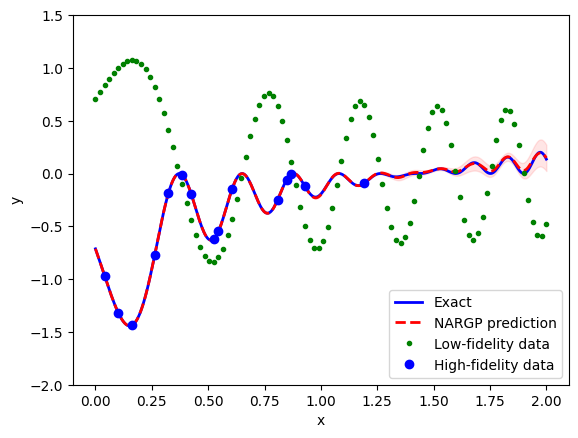

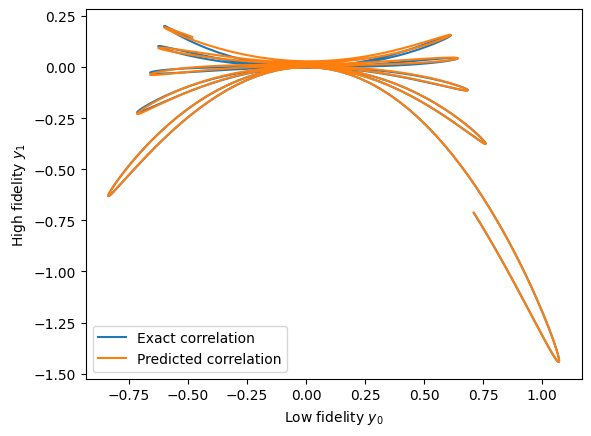

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Xtest, Exact, 'b', label='Exact', linewidth = 2)
ax.plot(Xtest, mean, 'r--', label = 'NARGP prediction', linewidth = 2)
ax.fill_between(Xtest.ravel(), (mean-2.0*np.sqrt(var)).ravel(), (mean+2.0*np.sqrt(var)).ravel(), alpha=0.1, color='red')
ax.plot(X1, Y1,'g.', label="Low-fidelity data")
ax.plot(X2, Y2,'bo', label="High-fidelity data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(-2,1.5)
ax.legend()
plt.show()

mean0, var0 = model_nargp.predict(Xtest,ifidelity=0)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Low, Exact, label = "Exact correlation")
ax.plot(mean0, mean, label = "Predicted correlation")
ax.set_xlabel(r"Low fidelity $y_0$")
ax.set_ylabel(r"High fidelity $y_1$")
ax.legend()
plt.show()

## (ii) Single GP using only high-fidelity data

In [5]:
data = [X2,Y2] # Single GP using only high-fidelity data
model_singlegp = SingleGP(data = data)
model_singlegp = SingleGP(
    data = data,
    kernel = KERNEL_NAME,
    normalize=True)
model_singlegp.optimize()

if KERNEL_NAME == "RBF":
    with open("model_singleGP_RBF.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "SpectralMixture":
    with open("model_singleGP_SMK.pkl","wb") as f:
        pickle.dump(model_singlegp,f)
elif KERNEL_NAME == "NeuralKernelNetwork":
    with open("model_singleGP_NKN.pkl","wb") as f:
        pickle.dump(model_singlegp,f)


# if KERNEL_NAME == "RBF":
#     with open("model_singleGP_RBF.pkl","rb") as f:
#         model_singlegp = pickle.load(f)
# elif KERNEL_NAME == "SpectralMixture":
#     with open("model_singleGP_SMK.pkl","rb") as f:
#         model_singlegp = pickle.load(f)
# elif KERNEL_NAME == "NeuralKernelNetwork":
#     with open("model_singleGP_NKN.pkl","rb") as f:
#         model_singlegp = pickle.load(f)


mean_singlegp, var_singlegp = model_singlegp.predict(Xtest)

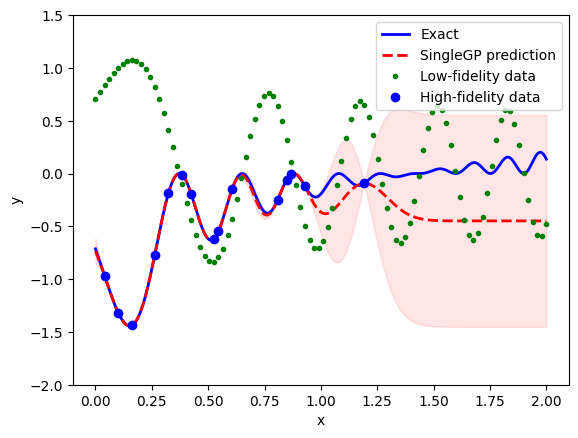

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(Xtest, Exact, 'b', label='Exact', linewidth = 2)
ax.plot(Xtest, mean_singlegp, 'r--', label = 'SingleGP prediction', linewidth = 2)
ax.fill_between(Xtest.ravel(), (mean_singlegp-2.0*np.sqrt(var_singlegp)).ravel(), (mean_singlegp+2.0*np.sqrt(var_singlegp)).ravel(), alpha=0.1, color='red')
ax.plot(X1, Y1,'g.', label="Low-fidelity data")
ax.plot(X2, Y2,'bo', label="High-fidelity data")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_ylim(-2,1.5)
ax.legend()
plt.show()